#  Numerical solution of games with nature

## Theory

### Win matrix

Let's assume that there are two players – the decision-maker (the first player, FP) and nature (the second player, SP).
FP has $m$ allowed types of activities (strategies), and nature can take $n$ different states. If the FP chooses the strategy $i\space (i\in\overline{1,m})$, and nature turns out to be in the state $j\space (j\in\overline{1,n})$, then the FP receives some winning $a_{ij}$. Then all the winnings can be reduced to a win matrix:

$$
A = \left(\begin{array}{cc} 
a_{11} & a_{12} & \dots & a_{1j} & \dots & a_{1n} \\
a_{21} & a_{22} & \dots & a_{2j} & \dots & a_{2n} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
a_{i1} & a_{i2} & \dots & a_{ij} & \dots & a_{in} \\
a_{m1} & a_{m2} & \dots & a_{mj} & \dots & a_{mn} \\
\end{array}\right)
$$

### Risk matrix

The risk matrix is associated with the win matrix. What is risk? Let nature take some state of $j$ (the $j$ column of winnings has been realized). In this situation, the FP can choose
one of its strategies, which is equivalent to choosing some row $i$. Among them there is a maximum $\beta_j = \underset{i=1,\dots,m}{max} a_{ij}$

If the FP selects a row other than the row of the maximum element, the winning will be less, and the risk of the winning can be calculated as the difference $r_{ij} = \beta_j − a_{ij} = \underset{i=1,\dots,m}{max} a_{ij} − a_{ij}$. The values of $r_{ij}$ are called risks. A risk matrix can be formed from them:

$$
R = \left(\begin{array}{cc} 
r_{11} & r_{12} & \dots & r_{1j} & \dots & r_{1n} \\
r_{21} & r_{22} & \dots & r_{2j} & \dots & r_{2n} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
r_{i1} & r_{i2} & \dots & r_{ij} & \dots & r_{in} \\
r_{m1} & r_{m2} & \dots & r_{mj} & \dots & r_{mn} \\
\end{array}\right)
$$

## Base Code

In [109]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [110]:
from IPython.display import clear_output

# install missing imports
%pip install numpy
%pip install matplotlib
clear_output()

In [111]:
import math
import numpy as np 
from abc import ABC, abstractmethod
from IPython.display import display, Latex
import matplotlib.pyplot as plt

In [112]:
class Game():
    def __init__(self):
        self.shape = (5,5)
        self.winnings = np.random.randint(-10, 10, size  = self.shape)
        self.rows = self.winnings.shape[0]
        self.columns = self.winnings.shape[1]
        self.risks = self._calculate_losses()
        self.condition_chances = self._generate_probabilities()
            
    def _calculate_losses(self):
        maximum_gains_per_column = np.amax(self.winnings, axis = 0)                        
        return np.reshape([maximum_gains_per_column - gain for gain in self.winnings], self.shape)

    def _generate_probabilities(self):
        list_of_random_floats = np.random.random(self.shape[1])
        sum_of_values = list_of_random_floats.sum()        
        normalized_values = list_of_random_floats / sum_of_values        
        return normalized_values

    def _is_probabilities_correct(states_probabilities : np.ndarray):        
        return math.isclose(states_probabilities.sum(), 1, abs_tol=10**-4)
    
    def summary(self):
        print("Game Stats:")     
        self.print_probabilities()
        self.print_winnings()           
        self.print_risks()        

    def print_winnings(self):
        print(f"Winnings: \n{self.winnings}")

    def print_risks(self):
        print(f"Risks:\n{self.risks}")
    
    def print_probabilities(self):
        print(f"Probabilities:\n{self.condition_chances}")


In [113]:
class CustomGame(Game):
    def __init__(self, winnings: np.ndarray, states_probabilities : np.ndarray = None):        
        dimensions = len(winnings.shape)
        if dimensions == 2:
            self.winnings = winnings
            self.shape = winnings.shape
            self.rows = winnings.shape[0]
            self.columns = winnings.shape[1]
            self.losses = self._calculate_losses()
            if states_probabilities == None or len(states_probabilities) != self.columns and self._is_probabilities_correct(states_probabilities):
                self.states_probabilities = self._generate_probabilities()
            else:
                self.states_probabilities = states_probabilities        
        else:
            # fallback to default constructor
            super().__init__()                    

In [114]:
class GameStrategyCriterion(ABC):
    def __init__(self, game: Game):        
        self.game = game
        self.optimal_choices = self._get_optimal_choices(game)                                        
        
    @abstractmethod
    def _get_optimal_choices(self, game):
        raise NotImplementedError()

    def get_choices(self):
        return self.optimal_choices
    
    def get_criterion_name(self) -> str:
        return type(self).__name__
                
    def _get_print_str(self) -> str:        
        if len(self.optimal_choices) > 1:
            return f"According to {self.get_criterion_name()} criterion, the optimal strategies are №{self.optimal_choices + 1}"
        else:
            return f"According to {self.get_criterion_name()} criterion, the optimal strategy is №{self.optimal_choices[0] + 1}"
    
    def summary(self):
        self.print()

    def print(self) -> None:
        print(f"{self._get_print_str()}.")              

In [115]:
class FunctionsResearchCriterion(GameStrategyCriterion):
    def __init__(self, game: Game):        
        self.game = game
        self.coefficients = self._get_coefficients()        
        super().__init__(game)        

    @abstractmethod
    def _get_tex_str(self, coe6fficients) -> str:
        raise NotImplementedError()

    @abstractmethod
    def plot():
        raise NotImplementedError()

    @abstractmethod
    def _get_coefficients(self):
        raise NotImplementedError()   

    def _get_optimal_choices(self, game):      
        l = np.linspace(0, 1, 1000)
        count = np.zeros(shape = game.rows, dtype=np.int32)         
    
        # could've just compare coefficients or solve analytically
        for point in l:
            fns_results = [self.function(point, *c) for c in self.coefficients]
            max_fn_result = np.amax(fns_results)
            idx = np.argwhere(fns_results == max_fn_result).flatten()
            for index in idx:
                count[index] += 1
                  
        max_count = np.amax(count)
        return np.argwhere(count == max_count).flatten()                     
        
    def summary(self):
        super().summary()
        self.print_functions()
        self.plot()

    def print_functions(self):                
        rows = self.game.rows
        columns = self.game.columns
        for index, c in enumerate(self.coefficients):
            if IN_COLAB:
                print(f"Strategy №{index + 1} function:")
                display(Latex(f"${self._get_tex_str(c)}$"))   
            else:
                display(Latex(f"Strategy №{index + 1} function: ${self._get_tex_str(c)}$"))   

In [116]:
class GameCriteriaPicksStats():
    def __init__(self, game: Game) -> None:
        self.criteria = []
        self.game = game
        pass

    def add_criterion(self, criterion: GameStrategyCriterion):
        self.criteria.append(criterion)        

    def hist(self):
        picks = []
        for criterion in self.criteria:
            picks += (criterion.get_choices() + 1).tolist()
                            
        # Set up the bins centered on the integers, i.e. -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. Then substract -0.5 to eliminate the extra bin at the end.
        bins = np.arange(1, self.game.rows + 1.5) - 0.5

        fig, ax = plt.subplots()
        counts, edges, bars = ax.hist(picks, bins, density=False, label="Picks") # density=True would make frequencies
        ax.set_xticks(bins + 0.5)        
    
        #plt.bar_label(bars)
        plt.ylabel('Count')
        plt.xlabel('Row Number Pick');        
        plt.legend(loc="upper left")
        plt.title("Criteria strategy picks histogram")
        
    def print(self):        
        for criterion in self.criteria:
            criterion.print()

    def summary(self):
        self.game.summary()
        self.print()
        self.hist()


## Criteria

### Wald's maximin model

$$ \underset{i}{max} \cdot \underset{j}{min} \cdot a_{ij} \space\space\space\space (i \in \overline{1,m}, \space j \in \overline{1,n}) $$

In [117]:
class WaldCriterion(GameStrategyCriterion):
    def _get_optimal_choices(self, game):
        mins = np.amin(game.winnings, axis = 1)
        self.maximin = np.amax(mins)        
        return np.argwhere(mins == self.maximin).flatten()

    def _get_print_str(self) -> str:
        return super()._get_print_str() + f" with the maximin of {self.maximin}"    
    
    def get_criterion_name(self) -> str:
        return "Wald's"        

### Savage Criterion (Minimax Regret)

$$\underset{i}{min} \cdot \underset{j}{max} \cdot r_{ij} \space\space\space\space (i \in \overline{1,m}, \space j \in \overline{1,n})$$

In [118]:
class SavageCriterion(GameStrategyCriterion):
    def _get_optimal_choices(self, game):
        maxs = np.amax(game.risks, axis = 1)
        self.minimax = np.amin(maxs)        
        return np.argwhere(maxs == self.minimax).flatten()

    def _get_print_str(self) -> str:
        return super()._get_print_str() + f" with the minimax of {self.minimax}"    

    def get_criterion_name(self) -> str:
        return "Savage"

### Maximum Expected Utility Criterion

$$\underset{i}{max} \sum_{j=1}^n a_{ij} y_{j} \space (i \in \overline{1,m})$$

In [119]:
class MaximumExpectedUtilityCriterion(GameStrategyCriterion):
    def _get_optimal_choices(self, game):                                        
        sums = [np.sum(gain * game.condition_chances) for gain in game.winnings]
        self.max = np.amax(sums)        
        return np.argwhere(sums == self.max).flatten() # we may use np.isclose(sums, self.max, abs_tol=10**-5) if we don't care if the strategies differ slightly

    def _get_print_str(self) -> str:
        return super()._get_print_str() + f" with the maximum expected gain of {self.max}" 
    
    def get_criterion_name(self) -> str:
        return "Maximum Expected Utility"

### Minimum Expected Risk Criterion
$$\underset{i}{min} \sum_{j=1}^n r_{ij} y_{j} \space (i \in \overline{1,m})$$

In [120]:
class MinimumExpectedRiskCriterion(GameStrategyCriterion):
    def _get_optimal_choices(self, game):  
        sums = [np.sum(risk * game.condition_chances) for risk in game.risks]                               
        self.min = np.amin(sums)
        return np.argwhere(sums == self.min).flatten() # we may use np.isclose(sums, self.min, abs_tol=10**-5) if we don't care if the strategies differ slightly
    
    def _get_print_str(self) -> str:
        return super()._get_print_str() + f" with the minimum expected risk of {self.min}"
    
    def get_criterion_name(self) -> str:
        return "Minimum Expected Losses"

### Hurwitz Criterion

$$g(i, \lambda) = \lambda \space \underset{j}{min} \space a_{ij} + (1-\lambda) \space \underset{j}{max} \space a_{ij} \space \space (i \in \overline{1,m})$$

In [121]:
class HurwitzCriterion(FunctionsResearchCriterion):
    def _get_coefficients(self):
        coefficients = []
        for gain in self.game.winnings:
            coefficients.append((np.min(gain), np.max(gain)))
        return coefficients

    def _get_optimal_choices(self, game):
        l = np.linspace(0, 1, 1000)        
        count = np.zeros(shape = game.rows, dtype=np.int32)

        # could've just compare coefficients or solve analytically
        for point in l:
            fns_results = [self.function(point, c[0], c[1]) for c in self.coefficients]
            max_fn_result = np.amax(fns_results)
            idx = np.argwhere(fns_results == max_fn_result).flatten()
            for index in idx:
                count[index] += 1
                  
        max_count = np.amax(count)
        return np.argwhere(count == max_count).flatten()
        
    def _get_tex_str(self, coefficients) -> str:    
        return f"g(i, \lambda) = {coefficients[0]}\lambda + {coefficients[1]}(1-\lambda)"
        
    def get_criterion_name(self) -> str:
        return "Hurwitz"

    def function(self, l, min, max):
        return l * min + (1 - l) * max

    def plot(self):
        fig = plt.figure()
        ax = plt.axes()
        l = np.linspace(0, 1, 2)
        plt.title(self.get_criterion_name())
        plt.xlabel("λ")
        plt.ylabel("g(i, λ)")              
        
        for index, c in enumerate(self.coefficients):        
            plt.plot(l, self.function(l, *c), color=np.random.random(3), label= "Strategy №%d" % (index + 1)) 

        plt.legend()
        plt.draw()
        



### Hodges–Lehmann Criterion

$$h(i, \lambda) = \lambda \space \underset{j}{min} \space a_{ij} + (1-\lambda) \space \sum_{j=1}^n \space a_{ij} \space y_{j} \space \space (i \in \overline{1,m})$$

In [122]:
class HodgesLehmannCriterion(FunctionsResearchCriterion):
    def _get_coefficients(self):
        coefficients = []
        for gain in self.game.winnings:
            coefficients.append((np.min(gain), np.sum(gain * self.game.condition_chances)))
        return coefficients
    
    def _get_tex_str(self, coefficients) -> str:
        return f"h(i, \lambda) = {coefficients[0]}\lambda + {coefficients[1]}(1-\lambda)"
    
    def get_criterion_name(self) -> str:
        return "Hodges-Lehmann"
        
    def function(self, l, min, sum):
        return l * min + (1 - l) * sum

    def plot(self):
        fig = plt.figure()
        ax = plt.axes()
        l = np.linspace(0, 1, 2)
        plt.title(self.get_criterion_name())
        plt.xlabel("λ")
        plt.ylabel("h(i, λ)")        

        for index, c in enumerate(self.coefficients):        
            plt.plot(l, self.function(l, *c), color=np.random.random(3), label= "Strategy №%d" % (index + 1)) 

        plt.legend()                

### Hodges-Lehmann Criterion (Modification 1)

$$u(i, \lambda) = \lambda \space \underset{j}{max} \space a_{ij} + (1-\lambda) \space \sum_{j=1}^n \space a_{ij} \space y_{j} \space \space (i \in \overline{1,m})$$

In [123]:
class HodgesLehmannCriterion_Modification1(FunctionsResearchCriterion):
    def _get_coefficients(self):
        coefficients = []
        for gain in self.game.winnings:
            coefficients.append((np.max(gain), np.sum(gain * self.game.condition_chances)))
        return coefficients

    def _get_tex_str(self, coefficients) -> str:
        return f"u(i, \lambda) = {coefficients[0]}\lambda + {coefficients[1]}(1-\lambda)"

    def get_criterion_name(self) -> str:
        return "Hodges-Lehmann (Mod 1)"

    def function(self, l, max, sum):
        return l * max + (1 - l) * sum

    def plot(self):
        fig = plt.figure()
        ax = plt.axes()
        l = np.linspace(0, 1, 2)
        plt.title(self.get_criterion_name())
        plt.xlabel("λ")
        plt.ylabel("u(i, λ)")        

        for index, c in enumerate(self.coefficients):        
            plt.plot(l, self.function(l, *c), color=np.random.random(3), label= "Strategy №%d" % (index + 1)) 
        plt.legend()        

### Hodges-Lehmann Criterion (Modification 2)

$$v(i, \space \lambda, \space \mu) = \lambda \space \underset{j}{min} \space a_{ij} + \mu \space \underset{j}{max} \space a_{ij} + (1-\lambda-\mu) \space \sum_{j=1}^n \space a_{ij} \space y_{j}\space \space (i \in \overline{1,m})$$


In [124]:
class HodgeLemanCriterion_Modification2(FunctionsResearchCriterion):
    def _get_coefficients(self):
        coefficients = []
        for gain in self.game.winnings:
            coefficients.append((np.min(gain), np.max(gain), np.sum(gain * self.game.condition_chances)))
        return coefficients
        
    def _get_optimal_choices(self, game):
        count = np.zeros(shape = game.rows, dtype=np.int32)
        _l = np.linspace(0, 1, 100)
        _u = np.linspace(0, 1, 100)
        l = []
        u = []                  
        for lp in _l:            
            for up in _u:
                if lp + up < 1:
                    l.append(lp)
                    u.append(up)
                    fns_results = [self.function(lp, up, *c) for c in self.coefficients]                    
                    max_fn_result = np.amax(fns_results)
                    idx = np.argwhere(fns_results == max_fn_result).flatten()
                    for index in idx:
                        count[index] += 1
        
        self.l = np.array(l)
        self.u = np.array(u)                                                         
        max_count = np.amax(count)
        return np.argwhere(count == max_count).flatten()  

    def _get_tex_str(self, coefficients) -> str:
        return f"v(i, \space \lambda, \space \mu) = {coefficients[0]}\lambda + {coefficients[1]}\mu + {coefficients[2]}(1-\lambda-\mu)"

    def get_criterion_name(self) -> str:
        return "Hodges-Lehmann (Mod 2)"

    def function(self, l, u, min, max, sum):
        return (l * min) + (u * max) + (1 - l - u) * sum

    def plot(self):        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.title(self.get_criterion_name())
        ax.set_xlabel('l')
        ax.set_ylabel('u')
        ax.set_zlabel('u(i, λ, μ)')
                                                  
        for index, c in enumerate(self.coefficients):                                                      
            ax.plot(self.l, self.u, self.function(self.l, self.u, *c), label= "Strategy №%d" % (index + 1))            
        
        plt.legend()
        ax.view_init(10, 30)
    

## Tests

In [125]:
game = Game()
game.summary()

Game Stats:
Probabilities:
[0.05042922 0.00776262 0.42608187 0.33649174 0.17923454]
Winnings: 
[[-10  -1   3  -5   9]
 [ -3   1   3  -4  -6]
 [ -6  -7   3  -5  -1]
 [ -5  -1   6   5  -9]
 [  0   2   8  -7   0]]
Risks:
[[10  3  5 10  0]
 [ 3  1  5  9 15]
 [ 6  9  5 10 10]
 [ 5  3  2  0 18]
 [ 0  0  0 12  9]]


In [126]:
game.print_winnings()
walds = WaldCriterion(game)
walds.summary()

Winnings: 
[[-10  -1   3  -5   9]
 [ -3   1   3  -4  -6]
 [ -6  -7   3  -5  -1]
 [ -5  -1   6   5  -9]
 [  0   2   8  -7   0]]
According to Wald's criterion, the optimal strategy is №2 with the maximin of -6.


In [127]:
game.print_risks()
savage = SavageCriterion(game)
savage.summary()

Risks:
[[10  3  5 10  0]
 [ 3  1  5  9 15]
 [ 6  9  5 10 10]
 [ 5  3  2  0 18]
 [ 0  0  0 12  9]]
According to Savage criterion, the optimal strategies are №[1 3] with the minimax of 10.


In [128]:
game.print_probabilities()
game.print_winnings()
max_utility = MaximumExpectedUtilityCriterion(game)
max_utility.summary()

Probabilities:
[0.05042922 0.00776262 0.42608187 0.33649174 0.17923454]
Winnings: 
[[-10  -1   3  -5   9]
 [ -3   1   3  -4  -6]
 [ -6  -7   3  -5  -1]
 [ -5  -1   6   5  -9]
 [  0   2   8  -7   0]]
According to Maximum Expected Utility criterion, the optimal strategy is №4 with the maximum expected gain of 2.3659303073587368.


In [129]:
game.print_probabilities()
game.print_risks()
min_risk = MinimumExpectedRiskCriterion(game)
min_risk.summary()

Probabilities:
[0.05042922 0.00776262 0.42608187 0.33649174 0.17923454]
Risks:
[[10  3  5 10  0]
 [ 3  1  5  9 15]
 [ 6  9  5 10 10]
 [ 5  3  2  0 18]
 [ 0  0  0 12  9]]
According to Minimum Expected Losses criterion, the optimal strategy is №4 with the minimum expected risk of 4.353819500247567.


According to Hurwitz criterion, the optimal strategy is №5.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

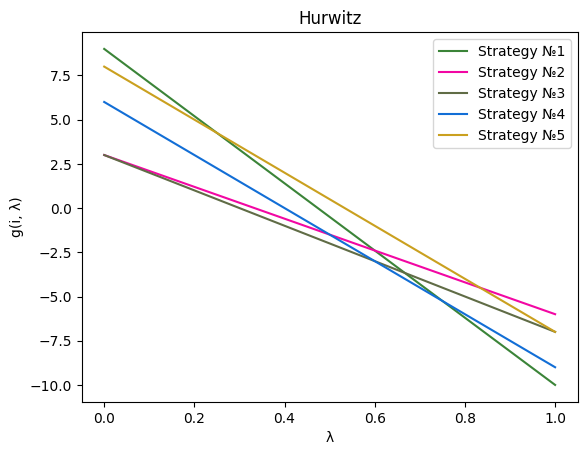

In [130]:
hurwitz = HurwitzCriterion(game)
hurwitz.summary()

According to Hodges-Lehmann criterion, the optimal strategy is №4.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

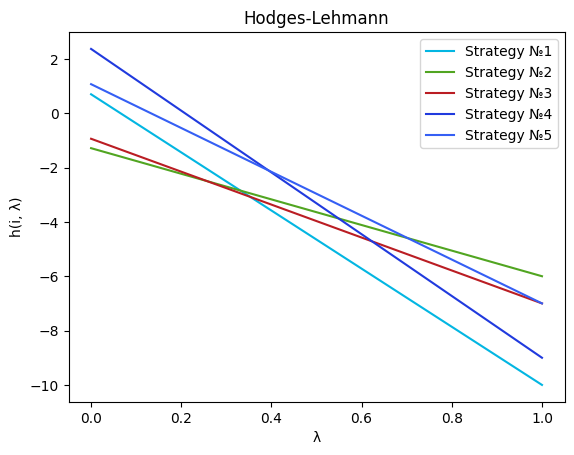

In [131]:
hodge_leman = HodgesLehmannCriterion(game)
hodge_leman.summary()

According to Hodges-Lehmann (Mod 1) criterion, the optimal strategy is №1.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

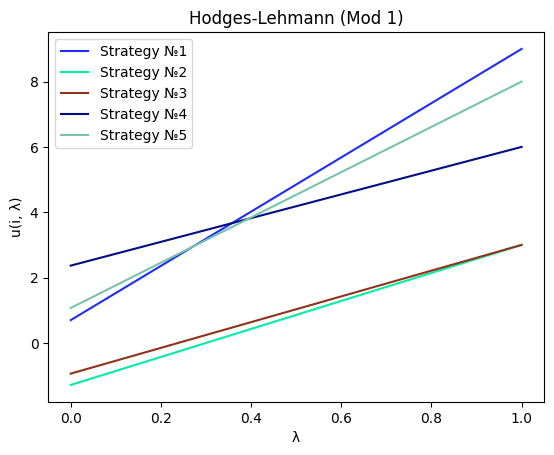

In [132]:
hodge_leman_m1 = HodgesLehmannCriterion_Modification1(game)
hodge_leman_m1.summary()

According to Hodges-Lehmann (Mod 2) criterion, the optimal strategy is №5.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

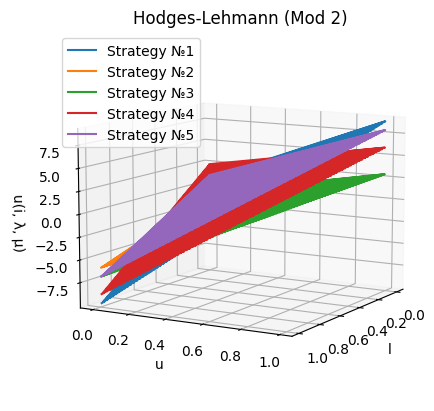

In [133]:
hodge_leman_m2 = HodgeLemanCriterion_Modification2(game)
hodge_leman_m2.summary()

## Statistics

In [134]:
stats = GameCriteriaPicksStats(game)
criteria = [walds, savage, max_utility, min_risk, hurwitz, hodge_leman, hodge_leman_m1, hodge_leman_m2]

for criterion in criteria:
    stats.add_criterion(criterion)

Game Stats:
Probabilities:
[0.05042922 0.00776262 0.42608187 0.33649174 0.17923454]
Winnings: 
[[-10  -1   3  -5   9]
 [ -3   1   3  -4  -6]
 [ -6  -7   3  -5  -1]
 [ -5  -1   6   5  -9]
 [  0   2   8  -7   0]]
Risks:
[[10  3  5 10  0]
 [ 3  1  5  9 15]
 [ 6  9  5 10 10]
 [ 5  3  2  0 18]
 [ 0  0  0 12  9]]
According to Wald's criterion, the optimal strategy is №2 with the maximin of -6.
According to Savage criterion, the optimal strategies are №[1 3] with the minimax of 10.
According to Maximum Expected Utility criterion, the optimal strategy is №4 with the maximum expected gain of 2.3659303073587368.
According to Minimum Expected Losses criterion, the optimal strategy is №4 with the minimum expected risk of 4.353819500247567.
According to Hurwitz criterion, the optimal strategy is №5.
According to Hodges-Lehmann criterion, the optimal strategy is №4.
According to Hodges-Lehmann (Mod 1) criterion, the optimal strategy is №1.
According to Hodges-Lehmann (Mod 2) criterion, the optimal s

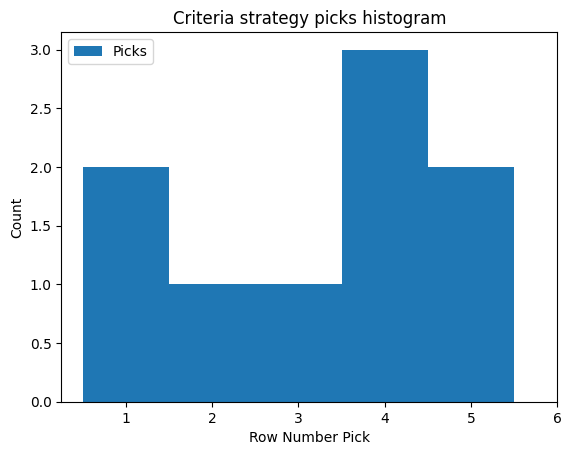

In [135]:
stats.summary()